# Sentiment Analysis using FastText

This notebook demonstrates the use of FastText for sentiment analysis. FastText is a library for efficient learning of word representations and sentence classification.

## Data Preparation

Before we start with the FastText model, we need to prepare our data. This involves cleaning the text data, removing stop words, and converting the text into numerical form.

```python
# Code for data preparation goes here

In [1]:
import pandas as pd
import numpy as np
import json
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Load Yelp reviews data
reviews = []
with open('yelp_academic_dataset_review.json', encoding='utf-8') as f:
    for line in f:
        review = json.loads(line)
        sentiment = 1 if review['stars'] >= 4 else 0
        reviews.append((review['text'], sentiment))

df = pd.DataFrame(reviews, columns=['text', 'sentiment'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jadak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jadak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df.head()

,text,sentiment
0,My wife took me here on my birthday for breakf...,1
1,I have no idea why some people give bad review...,1
2,love the gyro plate. Rice is so good and I als...,1
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1
4,General Manager Scott Petello is a good egg!!!...,1


In [11]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove URLs
    text = re.sub(r"https?://\S+|www\.\S+", "", text)

    # Remove random characters
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (IOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub("", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenise
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    filtered_tokens = [w for w in tokens if not w in stop_words and w.isalpha()]

    # Do stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return " ".join(stemmed_tokens)

In [12]:
df['processed_text'] = df['text'].apply(preprocess_text)
df.head(2)

,text,sentiment,processed_text
0,My wife took me here on my birthday for breakf...,1,wife took birthday breakfast excel weather per...
1,I have no idea why some people give bad review...,1,idea peopl give bad review place goe show plea...



## Model Training

Now that our data is prepared, we can train our FastText model. We use a batch size of 64 and train the model for 5 epochs.



In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment'], test_size=0.2, random_state=42)

In [14]:
from collections import Counter

def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

counter = counter_word(df.processed_text)
num_words = len(counter)
print(num_words)
counter

173921


Counter({'wife': 8814,
         'took': 18854,
         'birthday': 5052,
         'breakfast': 17945,
         'excel': 15995,
         'weather': 2485,
         'perfect': 17413,
         'made': 28697,
         'sit': 16361,
         'outsid': 13946,
         'overlook': 904,
         'ground': 2591,
         'absolut': 8782,
         'pleasur': 1337,
         'waitress': 11253,
         'food': 142972,
         'arriv': 10080,
         'quickli': 6150,
         'semibusi': 4,
         'saturday': 7638,
         'morn': 7232,
         'look': 51420,
         'like': 128345,
         'place': 170500,
         'fill': 10687,
         'pretti': 40076,
         'earlier': 1626,
         'get': 107898,
         'better': 33294,
         'favor': 1422,
         'bloodi': 1144,
         'mari': 1428,
         'phenomen': 1437,
         'simpli': 4155,
         'best': 44819,
         'ive': 47278,
         'ever': 25008,
         'im': 53424,
         'sure': 26973,
         'use': 27637,


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df.processed_text)
vocab_length = len(tokenizer.word_index)+1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=200)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

In [16]:
import gensim.downloader as api
pretrained_embedding_model = api.load("fasttext-wiki-news-subwords-300")
# pretrained_embedding_model = api.load("glove-wiki-gigaword-100")

In [17]:
embedding_dim = pretrained_embedding_model.vector_size

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in pretrained_embedding_model:
        embedding_matrix[i] = pretrained_embedding_model[word]

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

model = Sequential()

model.add(Embedding(input_dim=vocab_length,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=200,
                    trainable=False))
model.add(GRU(50))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [19]:
history = model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=64)

Epoch 1/5
2874/2874 [==============================] - 566s 196ms/step - loss: 0.4448 - accuracy: 0.7926 - val_loss: 0.3994 - val_accuracy: 0.8204
Epoch 2/5
2874/2874 [==============================] - 561s 195ms/step - loss: 0.3884 - accuracy: 0.8248 - val_loss: 0.3766 - val_accuracy: 0.8342
Epoch 3/5
2874/2874 [==============================] - 579s 201ms/step - loss: 0.3707 - accuracy: 0.8349 - val_loss: 0.3888 - val_accuracy: 0.8230
Epoch 4/5
2874/2874 [==============================] - 564s 196ms/step - loss: 0.3582 - accuracy: 0.8415 - val_loss: 0.3655 - val_accuracy: 0.8386
Epoch 5/5
2874/2874 [==============================] - 575s 200ms/step - loss: 0.3485 - accuracy: 0.8463 - val_loss: 0.3522 - val_accuracy: 0.8447



## Model Evaluation

After training, we evaluate our model on the test data to see how well it performs.

In [20]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print('Test accuracy:', accuracy)

1437/1437 [==============================] - 89s 62ms/step - loss: 0.3522 - accuracy: 0.8447
Test accuracy: 0.8447436094284058


In [ ]:
y_pred = model.predict(X_test_pad)

In [33]:
y_test

38088     1
83846     0
50042     0
72359     1
176699    1
         ..
45633     1
132180    1
53725     0
61639     1
27058     1
Name: sentiment, Length: 45982, dtype: int64

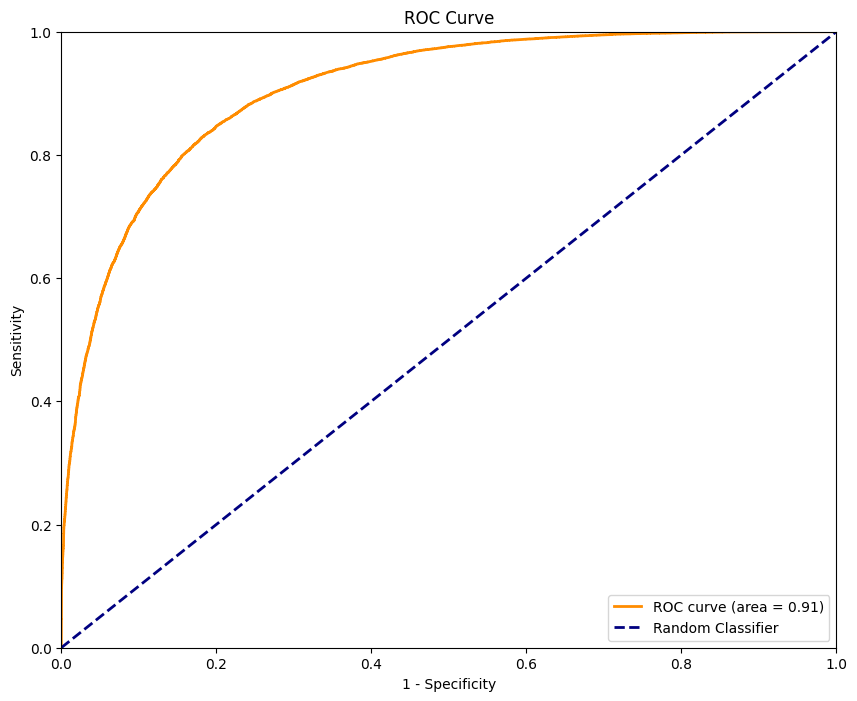

Threshold value is: 0.6596739


In [39]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# roc curve to y_test and y_pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Calculate the area under the ROC curve (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.title('ROC Curve')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc="lower right")
plt.show()

# get best threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

# get predictions based on optimal threshold
y_pred_optimal = [1 if i >= optimal_threshold else 0 for i in y_pred]

[[12086  2741]
 [ 5230 25925]]


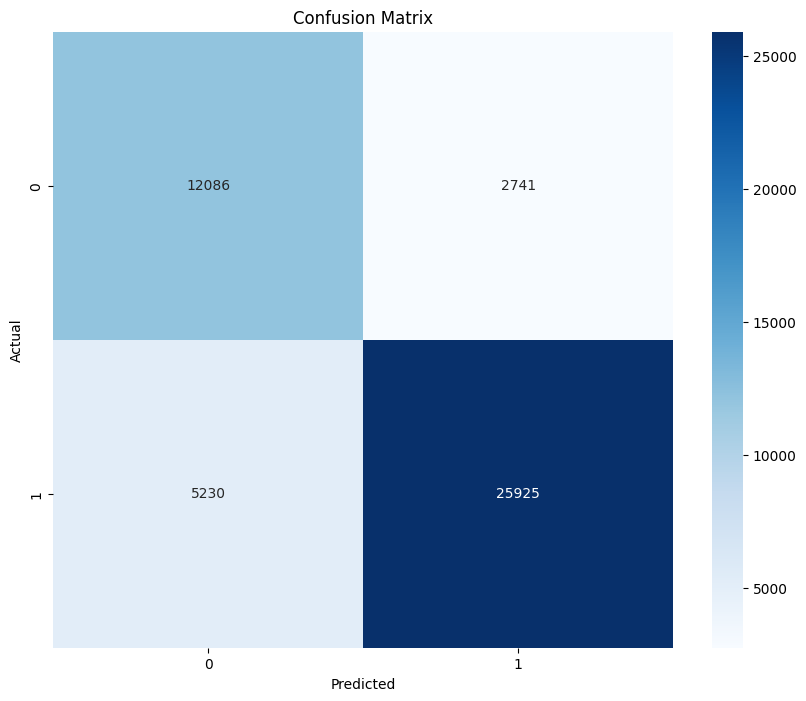

              precision    recall  f1-score   support

           0       0.70      0.82      0.75     14827
           1       0.90      0.83      0.87     31155

    accuracy                           0.83     45982
   macro avg       0.80      0.82      0.81     45982
weighted avg       0.84      0.83      0.83     45982



In [40]:
# get predictions based on optimal threshold
y_pred_optimal = [1 if i >= optimal_threshold else 0 for i in y_pred]

# confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)
print(cm)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# classification report
print(classification_report(y_test, y_pred_optimal))


In [10]:
def preprocess_and_predict(text):
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Convert to a sequence
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=200)

    # Predict
    prediction = model.predict(padded_sequence)

    return 'Positive' if prediction[0][0] > 0.5 else 'Negative'

In [ ]:
# Test with a positive review
input_text = "The food was absolutely wonderful, from preparation to presentation, very pleasing."
predicted_sentiment = preprocess_and_predict(input_text)
print(f'Review is: {predicted_sentiment}')

# Test with a negative review
negative_input_text = "Unfortunately, the experience was disappointing. The service was slow and the food was bland. Definitely not worth the price."
negative_predicted_sentiment = preprocess_and_predict(negative_input_text)
print(f'Review is: {negative_predicted_sentiment}')